### DL

In [ ]:
import pandas as pd

train_data = pd.read_csv("train_encoded.csv")
test_data = pd.read_csv("test_encoded.csv")
train_data.head()

,Comment,Emotion,Processed_Comment,Emotion_encoded
0,i didnt feel humiliated,sadness,not_feel humiliate,4
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damned hopeful around someone ca...,4
2,im grabbing a minute to post i feel greedy wrong,anger,grab minute post feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalgic fireplace know still property,3
4,i am feeling grouchy,anger,feel grouchy,0


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf


In [ ]:
# Tokenization avec vocabulaire dynamique
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Processed_Comment'])
vocab_size = len(tokenizer.word_index) + 1

# Calcul de la longueur moyenne pour le padding
text_lengths = train_data['Processed_Comment'].str.split().apply(len)
max_length = int(text_lengths.mean() + 2 * text_lengths.std())  # Couvre 95% des données

# Conversion et padding des séquences
def prepare_sequences(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train = prepare_sequences(train_data['Processed_Comment'], tokenizer, max_length)
X_test = prepare_sequences(test_data['Processed_Comment'], tokenizer, max_length)

# Préparation des labels
emotion_classes = train_data['Emotion'].unique()
num_classes = len(emotion_classes)
y_train = train_data['Emotion_encoded'].values
y_test = test_data['Emotion_encoded'].values

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Modèle corrigé sans input_length
minimal_model = Sequential([
    Embedding(input_dim=vocab_size,  # Taille du vocabulaire
              output_dim=128),       # Dimension d'embedding réduite

    LSTM(64),  # Couche LSTM unique avec 64 unités

    Dense(num_classes, activation='softmax')
])

# Compilation identique
minimal_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement
history = minimal_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
250/250 [==============================] - 17s 50ms/step - loss: 1.2485 - accuracy: 0.4861 - val_loss: 0.6904 - val_accuracy: 0.7165
Epoch 2/30
250/250 [==============================] - 11s 45ms/step - loss: 0.4988 - accuracy: 0.8141 - val_loss: 0.4724 - val_accuracy: 0.8335
Epoch 3/30
250/250 [==============================] - 13s 52ms/step - loss: 0.2309 - accuracy: 0.9269 - val_loss: 0.3746 - val_accuracy: 0.8715
Epoch 4/30
250/250 [==============================] - 11s 46ms/step - loss: 0.1362 - accuracy: 0.9556 - val_loss: 0.3985 - val_accuracy: 0.8735
Epoch 5/30
250/250 [==============================] - 12s 47ms/step - loss: 0.0998 - accuracy: 0.9673 - val_loss: 0.3908 - val_accuracy: 0.8805
Epoch 6/30
250/250 [==============================] - 12s 47ms/step - loss: 0.0759 - accuracy: 0.9739 - val_loss: 0.4394 - val_accuracy: 0.8770
Epoch 7/30
250/250 [==============================] - 11s 45ms/step - loss: 0.0677 - accuracy: 0.9774 - val_loss: 0.4340 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Prédictions
y_pred = minimal_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_classes)
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")

# Rapport détaillé
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_classes))

63/63 [==============================] - 2s 13ms/step
Accuracy: 0.8650
F1-Score (macro): 0.8203
F1-Score (weighted): 0.8665

Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.82      0.86       275
       anger       0.85      0.83      0.84       224
        love       0.90      0.87      0.89       695
    surprise       0.63      0.76      0.69       159
        fear       0.91      0.93      0.92       581
         joy       0.69      0.76      0.72        66

    accuracy                           0.86      2000
   macro avg       0.81      0.83      0.82      2000
weighted avg       0.87      0.86      0.87      2000



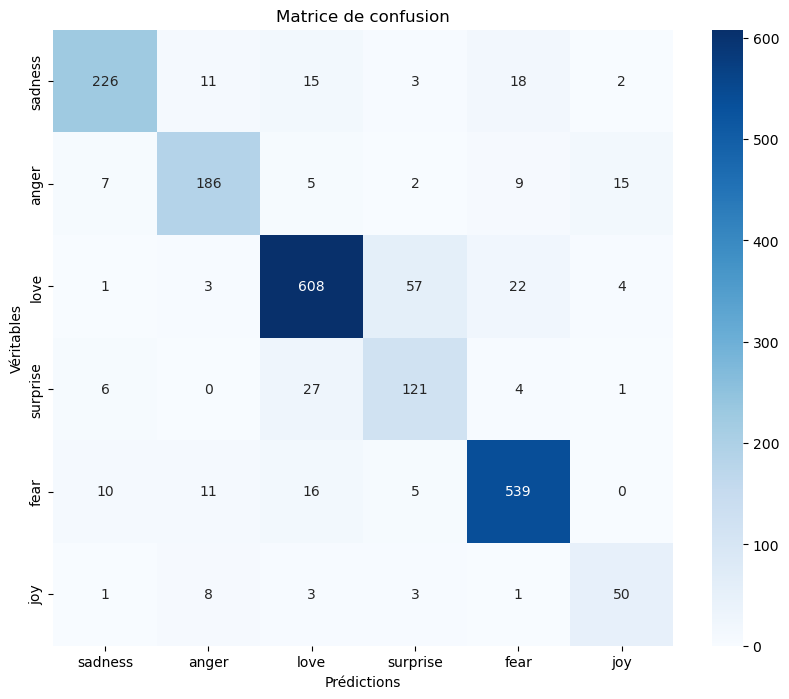

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion')
plt.show()


In [ ]:
## Ajout de class_weight (équilibrage des classes)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcule des poids de classes selon y_train (assure-toi qu'il est bien encodé)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

# Réentraîne ton modèle avec les poids
history2 = minimal_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights,  # ← Ajout ici
    verbose=1
)


Epoch 1/30
250/250 [==============================] - 14s 44ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.6942 - val_accuracy: 0.8690
Epoch 2/30
250/250 [==============================] - 10s 39ms/step - loss: 0.0168 - accuracy: 0.9928 - val_loss: 0.6987 - val_accuracy: 0.8645
Epoch 3/30
250/250 [==============================] - 10s 39ms/step - loss: 0.0136 - accuracy: 0.9941 - val_loss: 0.8091 - val_accuracy: 0.8585
Epoch 4/30
250/250 [==============================] - 10s 39ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 0.7617 - val_accuracy: 0.8625
Epoch 5/30
250/250 [==============================] - 10s 40ms/step - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.7996 - val_accuracy: 0.8630
Epoch 6/30
250/250 [==============================] - 9s 37ms/step - loss: 0.0116 - accuracy: 0.9957 - val_loss: 0.7594 - val_accuracy: 0.8640
Epoch 7/30
250/250 [==============================] - 10s 38ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.7318 - val_accuracy: 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Prédictions sur X_test
y_pred = minimal_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred_classes)
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")

# Rapport détaillé par classe (si tu as une liste des noms de classes)
emotion_classes = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_classes))


63/63 [==============================] - 1s 10ms/step
Accuracy: 0.8595
F1-Score (macro): 0.8070
F1-Score (weighted): 0.8609

Classification Report:
              precision    recall  f1-score   support

         joy       0.83      0.86      0.85       275
     sadness       0.85      0.85      0.85       224
       anger       0.93      0.86      0.89       695
        fear       0.66      0.72      0.69       159
        love       0.90      0.92      0.91       581
    surprise       0.61      0.71      0.66        66

    accuracy                           0.86      2000
   macro avg       0.80      0.82      0.81      2000
weighted avg       0.86      0.86      0.86      2000



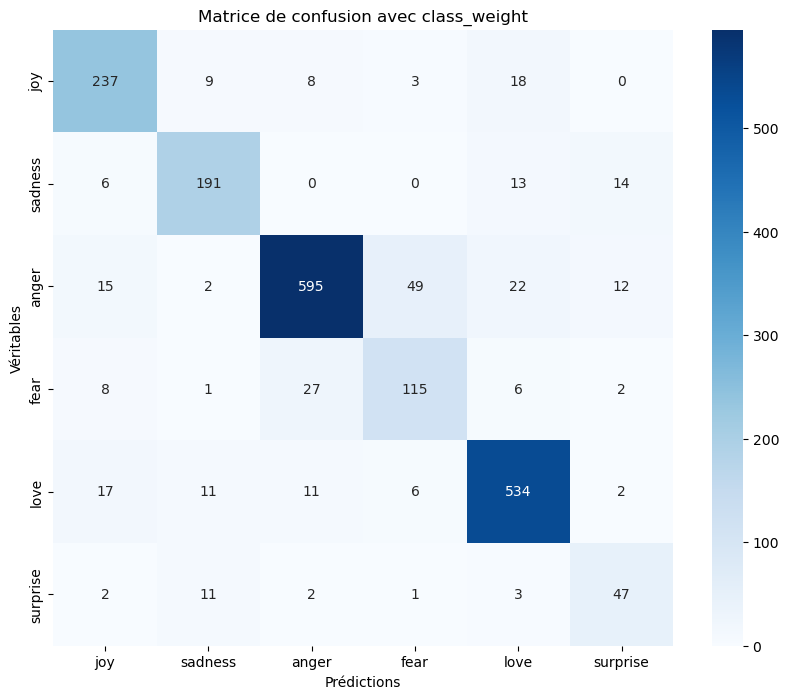

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affichage graphique
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion avec class_weight')
plt.show()


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 1. Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la nouvelle distribution des classes
print("Distribution après SMOTE :")
print(pd.Series(y_train_resampled).value_counts())

# 2. Calculer les class_weight (optionnel, mais utile pour le déséquilibre résiduel)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weights = dict(enumerate(class_weights))

# 3. Définir le modèle (exemple avec une architecture simple)
minimal_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    LSTM(128),
    Dense(6, activation='softmax')  # 6 classes d'émotions
])
minimal_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4. Entraîner avec SMOTE + class_weight
history = minimal_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),  # Validation sur les données originales (non sur-échantillonnées)
    class_weight=class_weights,
    verbose=1
)

Distribution après SMOTE :
4    5362
0    5362
3    5362
5    5362
1    5362
2    5362
Name: count, dtype: int64
Epoch 1/30
503/503 [==============================] - 34s 53ms/step - loss: 1.5723 - accuracy: 0.3317 - val_loss: 1.1362 - val_accuracy: 0.6490
Epoch 2/30
503/503 [==============================] - 24s 47ms/step - loss: 1.1695 - accuracy: 0.5513 - val_loss: 1.0256 - val_accuracy: 0.7150
Epoch 3/30
503/503 [==============================] - 24s 47ms/step - loss: 1.0084 - accuracy: 0.6110 - val_loss: 1.2559 - val_accuracy: 0.6875
Epoch 4/30
503/503 [==============================] - 28s 56ms/step - loss: 0.8979 - accuracy: 0.6544 - val_loss: 1.1703 - val_accuracy: 0.6935
Epoch 5/30
503/503 [==============================] - 27s 54ms/step - loss: 0.8040 - accuracy: 0.6956 - val_loss: 1.2943 - val_accuracy: 0.6845
Epoch 6/30
503/503 [==============================] - 30s 59ms/step - loss: 0.7154 - accuracy: 0.7303 - val_loss: 1.3457 - val_accuracy: 0.6770
Epoch 7/30
503/503 [===

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prédictions sur le jeu de test
y_pred = minimal_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Conversion des probabilités en classes
accuracy = accuracy_score(y_test, y_pred_classes)
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")
# 2. Rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred_classes, target_names=emotion_classes))





63/63 [==============================] - 2s 12ms/step
Accuracy: 0.6495
F1-Score (macro): 0.5820
F1-Score (weighted): 0.6804
Rapport de classification :
               precision    recall  f1-score   support

         joy       0.61      0.65      0.63       275
     sadness       0.56      0.73      0.63       224
       anger       0.91      0.59      0.72       695
        fear       0.34      0.58      0.43       159
        love       0.91      0.70      0.79       581
    surprise       0.19      0.67      0.29        66

    accuracy                           0.65      2000
   macro avg       0.59      0.65      0.58      2000
weighted avg       0.76      0.65      0.68      2000



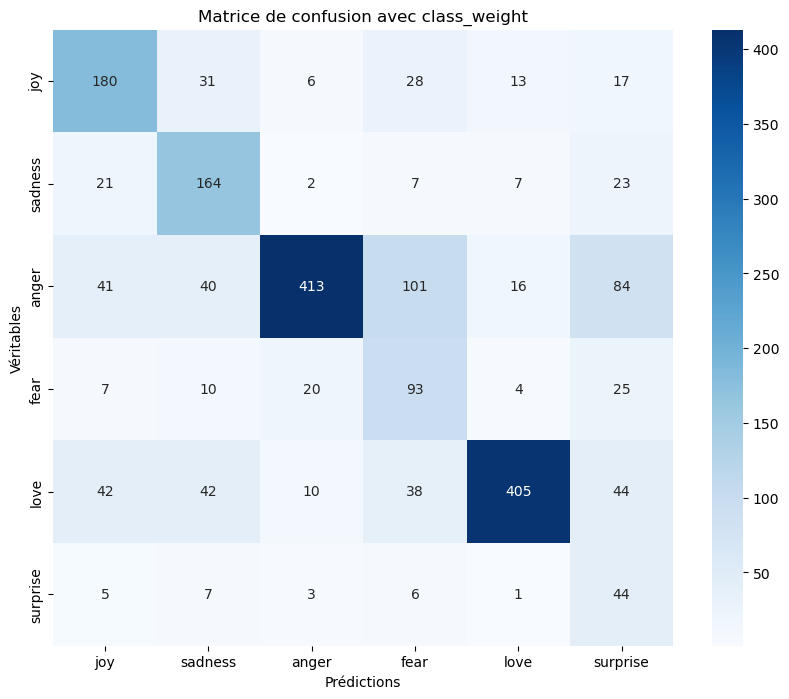

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affichage graphique
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion avec class_weight')
plt.show()


SMOTE a généré du bruit :
Les échantillons synthétiques de surprise et joy ne sont pas assez réalistes, ce qui fausse les prédictions.
Sur-optimisation : SMOTE a généré des échantillons artificiels de mauvaise qualité.
len déséquilibre résiduel nécessitant peut etre des poids personnalisés


In [ ]:


# 2. Préparation des données
print("Préparation des données...")

# Tokenization avec vocabulaire dynamique
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Processed_Comment'])
vocab_size = len(tokenizer.word_index) + 1

# Calcul de la longueur moyenne pour le padding
text_lengths = train_data['Processed_Comment'].str.split().apply(len)
max_length = int(text_lengths.mean() + 2 * text_lengths.std())  # Couvre 95% des données

# Conversion et padding des séquences
def prepare_sequences(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train = prepare_sequences(train_data['Processed_Comment'], tokenizer, max_length)
X_test = prepare_sequences(test_data['Processed_Comment'], tokenizer, max_length)

# Préparation des labels
emotion_classes = train_data['Emotion'].unique()
num_classes = len(emotion_classes)
y_train = train_data['Emotion_encoded'].values
y_test = test_data['Emotion_encoded'].values

# 3. Construction du modèle
print("Construction du modèle...")

model = Sequential([
    Embedding(vocab_size, 256),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Entraînement avec callbacks
print("Entraînement du modèle...")

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')  # Changement de .h5 à .keras
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Préparation des données...
Construction du modèle...
Entraînement du modèle...
Epoch 1/30
250/250 [==============================] - 63s 187ms/step - loss: 1.1823 - accuracy: 0.5248 - val_loss: 0.6189 - val_accuracy: 0.7385
Epoch 2/30
250/250 [==============================] - 36s 143ms/step - loss: 0.4209 - accuracy: 0.8512 - val_loss: 0.3162 - val_accuracy: 0.8915
Epoch 3/30
250/250 [==============================] - 39s 156ms/step - loss: 0.2126 - accuracy: 0.9280 - val_loss: 0.3312 - val_accuracy: 0.8935
Epoch 4/30
250/250 [==============================] - 49s 195ms/step - loss: 0.1355 - accuracy: 0.9537 - val_loss: 0.3029 - val_accuracy: 0.8990
Epoch 5/30
250/250 [==============================] - 39s 156ms/step - loss: 0.1054 - accuracy: 0.9633 - val_loss: 0.3256 - val_accuracy: 0.8970
Epoch 6/30
250/250 [==============================] - 44s 176ms/step - loss: 0.0796 - accuracy: 0.9719 - val_loss: 0.3760 - val_accuracy: 0.8930
Epoch 7/30
250/250 [==============================]

In [ ]:
# 5. Évaluation
print("Évaluation du modèle...")

# Chargement du meilleur modèle
model.load_weights('best_model.keras')

# Prédictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

Évaluation du modèle...
63/63 [==============================] - 6s 32ms/step


In [ ]:
# Prédictions
y_pred = model.predict(X_test)  # Sortie de prédiction

# Si y_pred est une probabilité (dimension 2D), il faut appliquer np.argmax pour obtenir la classe la plus probable
if len(y_pred.shape) == 2:  # Si y_pred a deux dimensions (probabilités)
    y_pred_classes = np.argmax(y_pred, axis=1)
else:  # Si y_pred est déjà une classe
    y_pred_classes = y_pred

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_classes)
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_classes))


63/63 [==============================] - 2s 31ms/step
Accuracy: 0.8990
F1-Score (macro): 0.8506
F1-Score (weighted): 0.8991

Classification Report:
              precision    recall  f1-score   support

     sadness       0.89      0.90      0.90       275
       anger       0.86      0.86      0.86       224
        love       0.92      0.94      0.93       695
    surprise       0.81      0.75      0.78       159
        fear       0.95      0.92      0.93       581
         joy       0.67      0.74      0.71        66

    accuracy                           0.90      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.90      0.90      0.90      2000



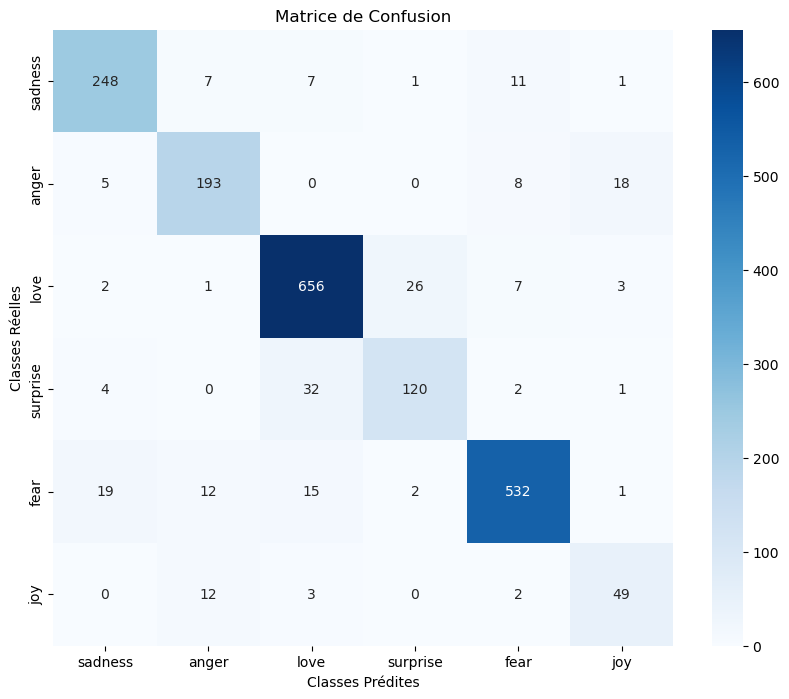

In [ ]:
# Assurez-vous que y_pred_classes contient les classes prédites
cm = confusion_matrix(y_test, y_pred_classes)

# Configuration de la taille de la figure et affichage de la heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes, cmap="Blues")
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()

In [ ]:
# -----------------------------
# 1. BiLSTM avec Embeddings GloVe pré-entraînés
# -----------------------------

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, f1_score
import os

# --- Charger les données (réutilise tes variables existantes) ---
train_data = pd.read_csv("train_encoded.csv")
test_data = pd.read_csv("test_encoded.csv")

# --- Préparer les séquences (même que avant) ---
MAX_VOCAB_SIZE = 15000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Processed_Comment'])

# Longueur de séquence
text_lengths = train_data['Processed_Comment'].str.split().apply(len)
max_length = int(text_lengths.mean() + 2 * text_lengths.std())

def prepare_sequences(texts, tokenizer, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

X_train = prepare_sequences(train_data['Processed_Comment'], tokenizer, max_length)
X_test = prepare_sequences(test_data['Processed_Comment'], tokenizer, max_length)
y_train = train_data['Emotion_encoded'].values
y_test = test_data['Emotion_encoded'].values
num_classes = len(np.unique(y_train))

# --- Télécharger et charger GloVe (100d) ---
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -n glove.6B.zip

def load_glove_embeddings(filepath, dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt', dim=100)
print(f"✅ {len(glove_embeddings)} mots chargés depuis GloVe.")

# --- Créer matrice d'embeddings initialisée avec GloVe ---
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # Sinon : reste à zéro (pour OOV)

# --- Construire le modèle ---
glove_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],  # ⬅️ Initialisation avec GloVe
        trainable=False,             # ⬅️ Geler les embeddings (optionnel : met à True pour fine-tuner)
        input_length=max_length
    ),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

glove_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Entraînement ---
print("🧠 Entraînement BiLSTM + GloVe...")
history_glove = glove_model.fit(
    X_train, y_train,
    epochs=15,  # souvent converge plus vite
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# --- Évaluation ---
y_pred = np.argmax(glove_model.predict(X_test), axis=1)
f1_glove = f1_score(y_test, y_pred, average='macro')
print(f"\n✅ BiLSTM + GloVe → F1-macro : {f1_glove:.4f}")

--2025-12-10 17:01:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-10 17:01:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-10 17:01:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


🧠 Entraînement BiLSTM + GloVe...
Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4028 - loss: 1.5147 - val_accuracy: 0.5790 - val_loss: 1.1271
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5450 - loss: 1.2215 - val_accuracy: 0.6905 - val_loss: 0.8249
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6273 - loss: 1.0132 - val_accuracy: 0.7755 - val_loss: 0.6795
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6574 - loss: 0.9131 - val_accuracy: 0.8110 - val_loss: 0.5410
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7220 - loss: 0.7682 - val_accuracy: 0.8535 - val_loss: 0.4450
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7469 - loss: 0.6967 - val_accuracy: 0.8595 - val_loss: 0.3923
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7692 - loss: 0.6273 - val_accuracy: 0.8705 - val_loss: 0.3690
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy